# Принятие решений в бизнесе (A/B-тест)

Вместе с маркетинговым отделом мы подготовили список гипотез для увеличения выручки интернет-магазина.
Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать полученные результаты.

<b> Цели данного проекта</b>:
1. Определение гипотезы, которая является самой значимой на текущий момент из всех предложенных идей.

Какие задачи необходимо выполнить:\
Применяем фреймворк ICE и RICE для определения наиболее приоритетной.

2. Проведение А\В теста выбранной гипотезы и предоставление результата по окончании теста. \

<b> Задачи</b>:
- анализ графиков куммулятивной выручки, среднего чека и среднего кол-ва заказов по группам
- анализ графиков этих же относительных значений
- выявить количество аномальных пользователей и границу аномально дорогих заказов.
- посчитать стат значимость различий среднего чека и кол-ва заказов по сырым и очищенным данным.

3. Определение успешности данного теста, закончен ли он, стоит его продолжить или прекратить ввиду больших убытков.

<b>Описание данных</b> \
Данные для первой части:

Hypothesis — краткое описание гипотезы; \
Reach — охват пользователей по 10-балльной шкале; \
Impact — влияние на пользователей по 10-балльной шкале; \
Confidence — уверенность в гипотезе по 10-балльной шкале; \
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части: \
orders \
transactionId — идентификатор заказа; \
visitorId — идентификатор пользователя, совершившего заказ; \
date — дата, когда был совершён заказ; \
revenue — выручка заказа; \
group — группа A/B-теста, в которую попал заказ. 

visitors \
date — дата; \
group — группа A/B-теста; \
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

 ## Часть 1. Приоритизация гипотез

Для начала посмотрим на гипотезы, которые у нас есть и определимся с наиболее приоритетной, для которой будем проводить A/B тест.

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
import scipy.stats as stats

In [2]:
#прочитаем данные из файла и сохраним датафрейм в новой переменной data
try:
    data = pd.read_csv('/datasets/hypothesis.csv')
except:
    data = pd.read_csv(r'C:\Users\Irina\Desktop\Analitic_projects\datasets\hypothesis.csv')
    
pd.options.display.max_colwidth = 150  #настроим полное отображение текста при выводе  
data.info() #проверим сколько строк в датафрейме
data.head(10) #выведем их на экран

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
#приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.head(5)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Рассчитаем приоритетность гипотез фреймворка ICE

In [4]:
#добавим новый столбец с расчетом фреймворка ICE
data['ice'] = data['impact'] * data['confidence'] / data['efforts']

#выведем на экран 2 столбца с названием гипотезы и значением ICE, отсортированные по убыванию
# и округлим значения до 2 знаков после запятой
round(data[['hypothesis', 'ice']].sort_values(by='ice', ascending=False), 2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По методу ICE 3 наиболее приоритетные гипотезы 8, 0 и 7 со значениями ICE 16, 13 и 11 соответственно.\
Лидирует гипотеза 8.

Теперь сделаем аналогичный расчет фреймворка RICE.

In [5]:
#добавим новый столбец с расчетом фрейсворка RICE
data['rice'] = data['reach'] * data['impact'] * data['confidence'] / data['efforts']

#выведем на экран 2 столбца с названием гипотезы и значением RICE, отсортированные по убыванию
# и округлим значения до 2 знаков после запятой
round(data[['hypothesis', 'rice']].sort_values(by='rice', ascending=False), 2)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


RICE отличается от ICE добавлением параметра reach. 
Этот параметр учитывает количество пользователей, которых затронет изменение.

Наш лидер фреймфорка ICE - гипотеза 8 теперь откатился назад на 5 место. 
Это можно объянить тем, что применив гипотезу охвачены будут не так много пользователей по сравнению \
с остальными гипотезами.

А вот гипотеза 7, наоборот, вырвалась вперед, да еще и с каким отрывом от остальных! 
Для 7 гипотезы значение RICE в 2 раза превышает все остальные.
У ее показатель reach - максимальный. Т.о., охватывает наибольшее количество пользователей 
и в фреймворке RICE является наиболее приоритетным.
Что в совокупности с остальными параметрами делает 7 гипотезу явным лидером при исследовании.

Гипотеза 0 удерживает хорошие позиции как в случае с ICE (2 место), 
так и при подсчете фреймфорка RICE (3 место). Так что эту гипотезу вполне можно рассмотреть для дальнейших 
тестов.

## Часть 2. Анализ A/B-теста

Для начала прочитаем данные, которые были получены в результате A/B теста.

In [6]:
#прочитаем датафрейм и сохраним его в новой переменной orders

try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv(r'C:\Users\Irina\Desktop\Analitic_projects\datasets\orders.csv')
    
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

#прочитаем датафрейм и сохраним его в новой переменной visitors
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv(r'C:\Users\Irina\Desktop\Analitic_projects\datasets\visitors.csv')

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

#выведем на экран оба датафрейма
display(orders.head())
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Теперь необходимо провести проверку данных, чтобы понять какой тест применять и правомерно ли это делать.

In [7]:
#узнаем какие уникальные значения кроются в столбце group
print(orders['group'].unique())

visitors['group'].unique()

['B' 'A']


array(['A', 'B'], dtype=object)

Только 2 возможных значения - А и В, значит тест у нас парный. \
Будем сравнивать 2 группы между собой. 
А - контрольная, В - тестируемая.

In [8]:
#определим даты начала и конца теста
print('Мин дата датафрейма по заказам', orders['date'].min())
print('Макс дата датафрейма по заказам',orders['date'].max())

print('Мин дата датафрейма по пользователям', visitors['date'].min())
print('Макс дата датафрейма по пользователям', visitors['date'].max())

Мин дата датафрейма по заказам 2019-08-01 00:00:00
Макс дата датафрейма по заказам 2019-08-31 00:00:00
Мин дата датафрейма по пользователям 2019-08-01 00:00:00
Макс дата датафрейма по пользователям 2019-08-31 00:00:00


Тест у нас длится 1 месяц - с 1 по 31 августа 2019 года. \
Вполне нормальная длительность теста, в течение которого можно увидеть результат.

In [9]:
#Теперь нужно понять как распределены пользователи по группам, одинаковое ли их число в каждой группе.
#посчитаем кол-во пользователей в каждой группе

ordA = orders[orders['group'] == 'A']['visitorId'].unique()

print('Количество пользовательских заказов группы А', pd.Series(ordA).count())

ordB = orders[orders['group'] == 'B']['visitorId'].unique()

print('Количество пользовательских заказов группы B', pd.Series(ordB).count())

# процент пользователей группы В
print( 'Кол-во процентов польз группы В', round(pd.Series(ordB).count() * 100/ \
                                                (pd.Series(ordA).count() + pd.Series(ordB).count()), 2)) 


visA = visitors[visitors['group'] == 'A']['visitors'].sum()

print('')
print('Количество уникальных пользователей группы А', pd.Series(visA))

visB = visitors[visitors['group'] == 'B']['visitors'].sum()

print('Количество уникальных пользователей группы B', pd.Series(visB))

#сделаем сводную таблицу, которая покажет результат более лаконично
vis_group = visitors.groupby('group').agg({'visitors': 'sum'})
vis_group['share'] = vis_group['visitors'] / vis_group['visitors'].sum()
vis_group

Количество пользовательских заказов группы А 503
Количество пользовательских заказов группы B 586
Кол-во процентов польз группы В 53.81

Количество уникальных пользователей группы А 0    18736
dtype: int64
Количество уникальных пользователей группы B 0    18916
dtype: int64


,visitors,share
group,,
A,18736,0.49761
B,18916,0.50239


В группе В пользовательских заказов больше чем у группы А ( 53% против 47%). \
Но 1 пользователь может сделать несколько заказов, поэтому неравномерность данного распределния не критичина для нас и здесь нет никаких противоречий.

А вот распределение по группам уникальных пользователей, как видно из сводной таблицы очень близко к 50\50 с небольшой погрежностью в пределах нормы ( менее 1 %). Условно будет считать, что они распределены поровну.

In [10]:
# И последнее что нам надо учесть - нет ли в данных перекрестных пользователей, 
# т.е. тех, кто попал и в группу А и в группу В.

pd.Series(ordA).isin(pd.Series(ordB)).value_counts()


False    445
True      58
dtype: int64

Итак, у нас действительно есть перекающиеся пользователи - 58 человек. Это не так мало, но на самом деле, если мы удалим их из исследования, то это может повлечь за собой совершенно некорректные результаты,т.е. они могут у нас сильно исказить картину. Поэтому принимаем решение оставить их в исследовании и никого не удалять.

In [11]:
#проверим датафрейм на дубликаты и пропуски значений
print(orders.isna().sum())

orders.duplicated().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


0

Пропусков и дубликатов нет, супер, двигаемся дальше!

### График кумулятивной выручки по группам

Создадим массив уникальных пар значений и групп теста

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups\
        .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
                                       orders['group'] == x['group'])]\
       .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}),\
       axis=1)\
       .sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
        .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Теперь перейдем к простроению графика кумулятивной выручки

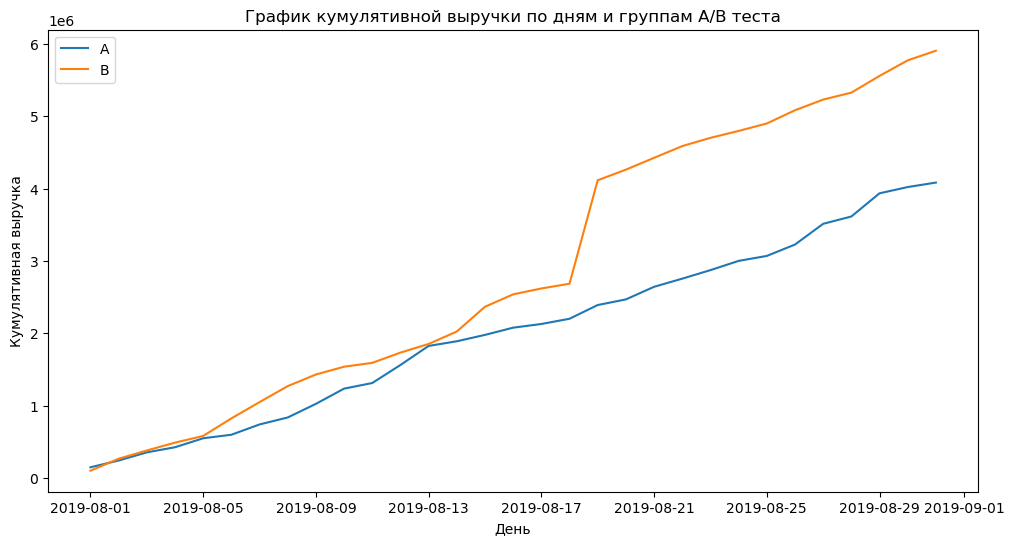

In [13]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по дням и группам A/B теста')
plt.xlabel('День')
plt.ylabel('Кумулятивная выручка')

plt.legend(); 

Выручка стабильно растет в процессе прохождения теста для обеих групп. 
В первой половине теста значения выручки примерно на одном уровне и растут линейно. Хотя группа B совсем немного опережает. 

Начиная с 2019-08-18 у группы B идет резкий скачок роста, после чего выручка продолжает линейно расти, 
но уже имеет сильное расхождение по сравнению с группой А.
У группы А кумулятивная выручка имеет линейный характер без каких-либо всплесков и падений.

Резкий скачок для группы В может быть признаком того, что в этот период были слишком дорогие заказы или неожиданный рост количества заказов. Проверим наши догадки дальше.

К концу теста группа В показала большую выручку по сравнению с гр А.

### График кумулятивного среднего чека по группам

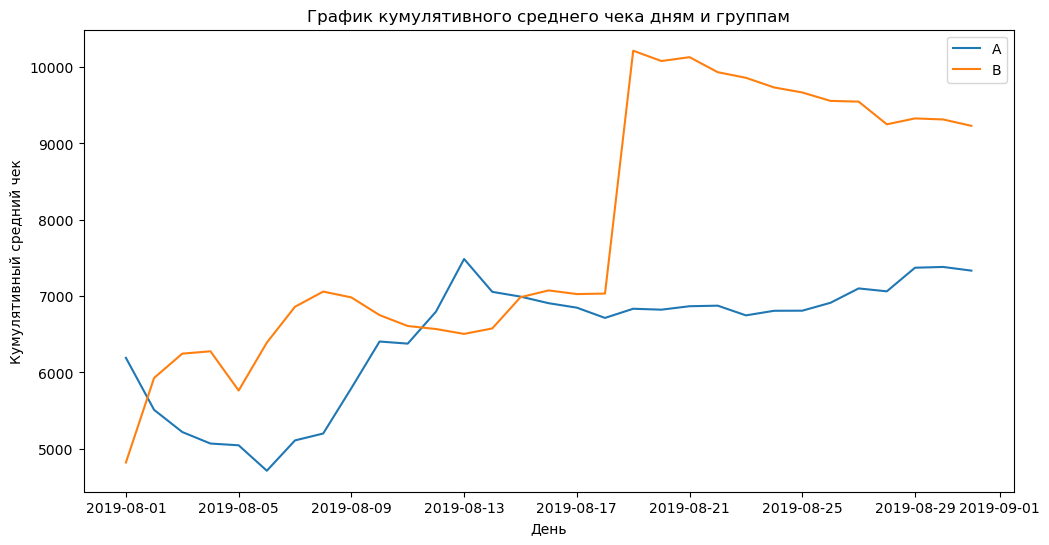

In [14]:
#построим график кумулятивного среднего чека по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека дням и группам')
plt.xlabel('День')
plt.ylabel('Кумулятивный средний чек')
plt.legend(); 

Да, видим подтверждение одной нашей гипотезы - для группы В 18 числа произошел резкий скачок 
среднего чека (его повышение). Что и позволило добиться увеличения выручки для этой группы.

После скачка средний чек гр. В постепенно начал снижаться, но при этом в совокупности средний чек 
все же остался выше, чем у группы А.

В начале теста группы ведут себя по разному. даже имеют противоположный характер поведения. Когда у гр А падает средний чек, то у гр В он немного растет, и наоборот.

13 числа у группы А было максимальное значение кумулятивного среднего чека, а у группы В в этот момент был небольшой спад.
Тауде следует отметить, что сначале теста он еще не успел установиться и стабилизироваться.

### График относительного различия для среднего чека

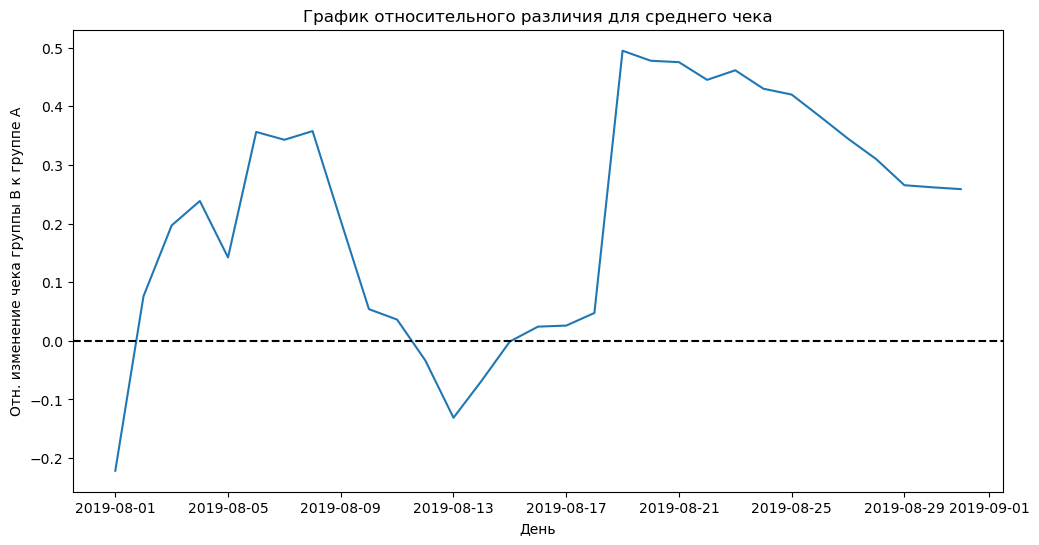

In [15]:
# объединяем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', \
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('График относительного различия для среднего чека')
plt.xlabel('День')
plt.ylabel('Отн. изменение чека группы B к группе A')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

<b>Вывод:</b>\
За некоторые периоды есть очень резкие "скачки" относит развития. 13 числа - провал и уход в минус, т.е. группа В была ниже по среднему чеку относительно группы А. 

Но в целом если смотреть на весь период, то есть 2 пика где В давлеет над А. 
Также в подтверждение нашей гипотезы - 18 числа явно виден резкий скачок вверх этого различия, и это говорит о том, что точно были крупные заказы с большим чеком.

### График кумулятивного среднего количества заказов на посетителя

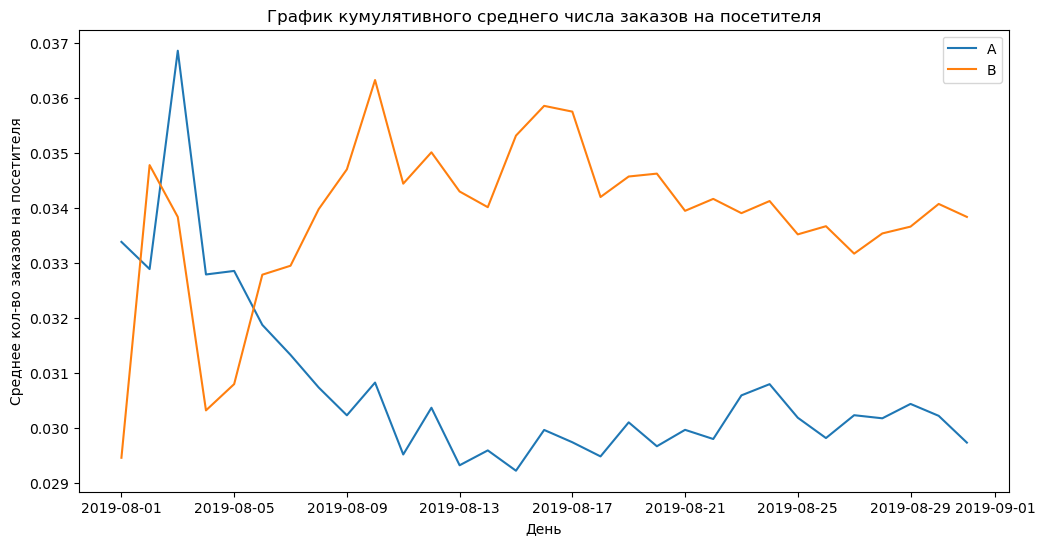

In [16]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего числа заказов на посетителя')
plt.xlabel('День')
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.legend();


В начале теста обе группы колебались и у группы А среднее кол-во заказов даже было чуть выше, но с 5 числа группы поменялись местами
и с этого момента до окончания теста для группы В среднее всегда выше. 
Небольшие колебания сохранились, но в целом тенденция видна - среднее число заказов на посетителя для группы В преобладает над этим значением для группы А.

### График относительного изменения кумулятивного среднего количества заказов

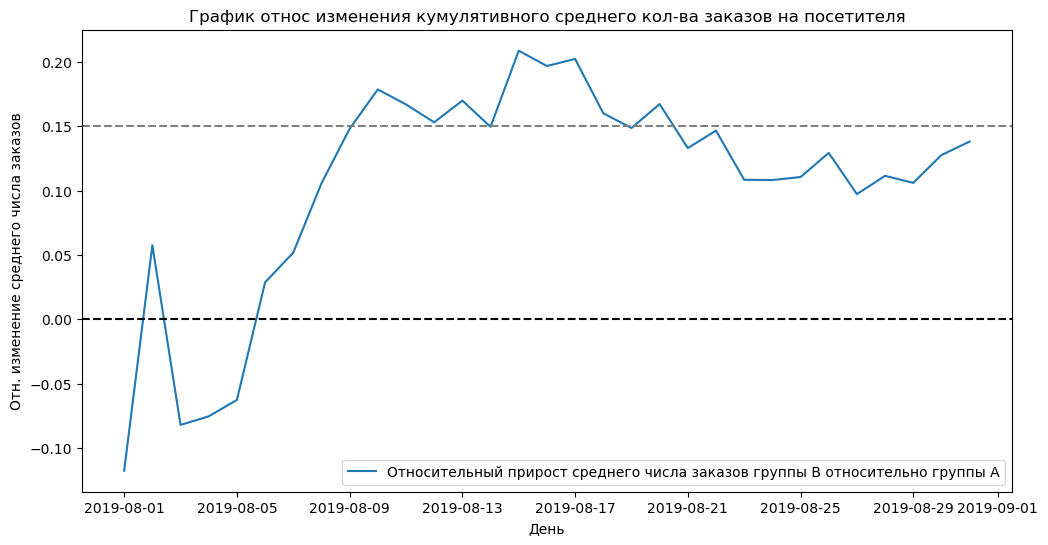

In [17]:
#объединим кумулятивные данные по группам
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1, \
         label="Относительный прирост среднего числа заказов группы B относительно группы A")
plt.title('График относ изменения кумулятивного среднего кол-ва заказов на посетителя')
plt.xlabel('День')
plt.ylabel('Отн. изменение среднего числа заказов')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');
 

В начале теста относит. изменение среднего числа заказов было ниже 0, т.е. группа А давала лучше результат, чем группа В. 

Начиная с 5 числа, относит изменение среднего числа заказов было выше 0 всегда, т.е. группа В взяла вверх над А и давала результат лучше. 
С течением теста отн изменение среднего росло, достигло пика в районе 17 числа, потом немного пошло на спад и устремилось к значению 0,15.

### Точечный график количества заказов по пользователям

Подсчитаем количество заказов по пользователям и посмотрим на результат

In [18]:
#добавим новую переменную распределения количества заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Видим, что было несколько пользователей. которые сделали по 5, 9 и даже 11 заказов. 
Это все же больше, чем совершает среднестатистический пользователь. 
И эти данные могут исказить результаты А\В теста.

Посмотрим как распределены в целом количества заказов.

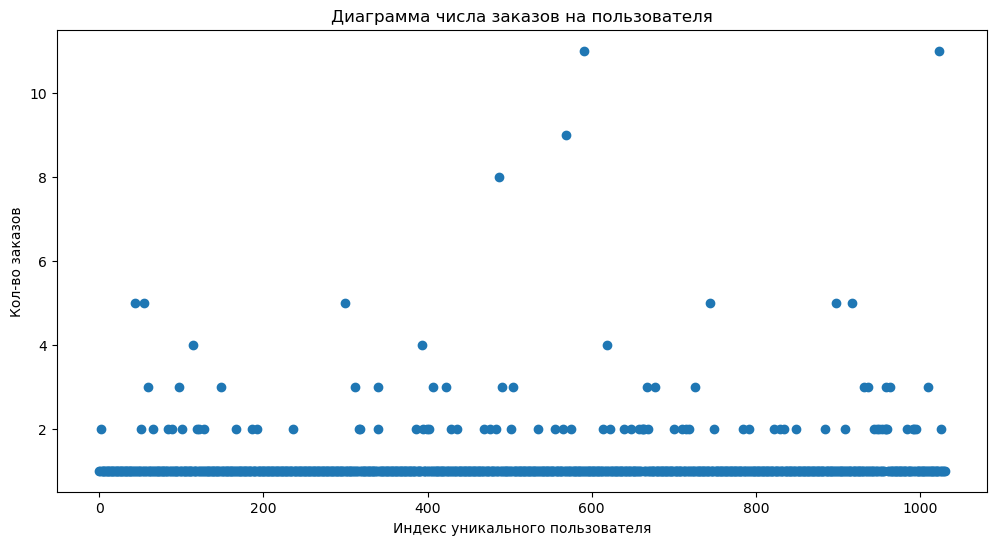

In [19]:
#для этого построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Диаграмма числа заказов на пользователя')
plt.xlabel('Индекс уникального пользователя')
plt.ylabel('Кол-во заказов'); 

Большинство посетителей совершили по 1-2 заказа. Все что больше 3 заказов (примерно) - это редкие исключения.

Для того, чтобы точно сказать в процентном соотношении закое число заказов совершали менее 5% посетителей,
то посчитаем это через перцентили.

### Перцентили количества заказов на пользователя

In [20]:
#подсчет 95 и 99 перцентиля по кол-ву заказов на одного пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Итак, теперь точно можем сказать, что меньше 5% пользователей делают более 2 заказов.\
И менее 1% пользователей совершают более 4 заказов. 

В качестве аномальных данных обычно принимают от 1 до 5% значений в зависимости от целей. 
В нашем случае для анализа результатов А\В теста, можно взять промежуточный вариант - 3 заказа. 
Т.е. от 1 до 5 % пользователей совершают более 3 заказов. Их будем исключать из дальнейших исследований.

### Точечный график стоимостей заказов

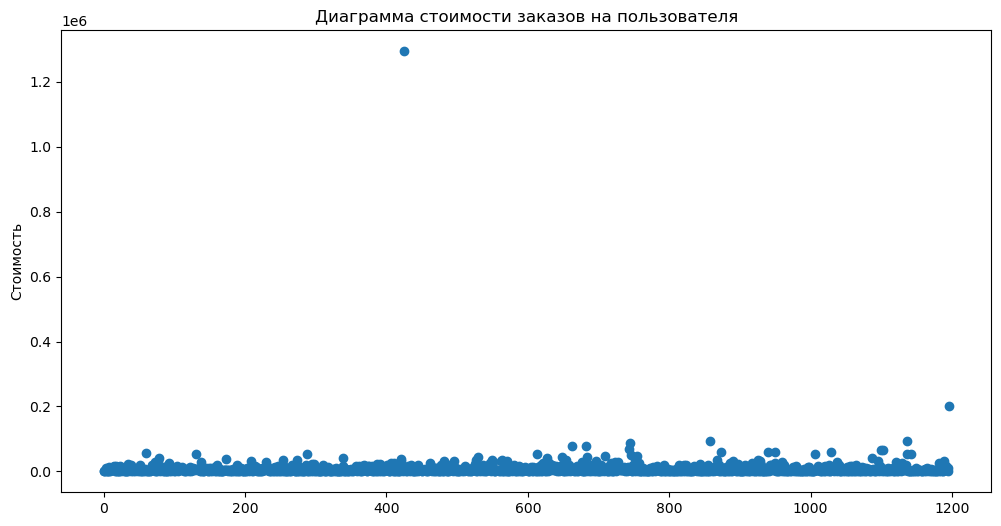

In [21]:
#построим точечную диаграмму стоимости заказов на одного пользователя
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма стоимости заказов на пользователя')
plt.ylabel('Стоимость');

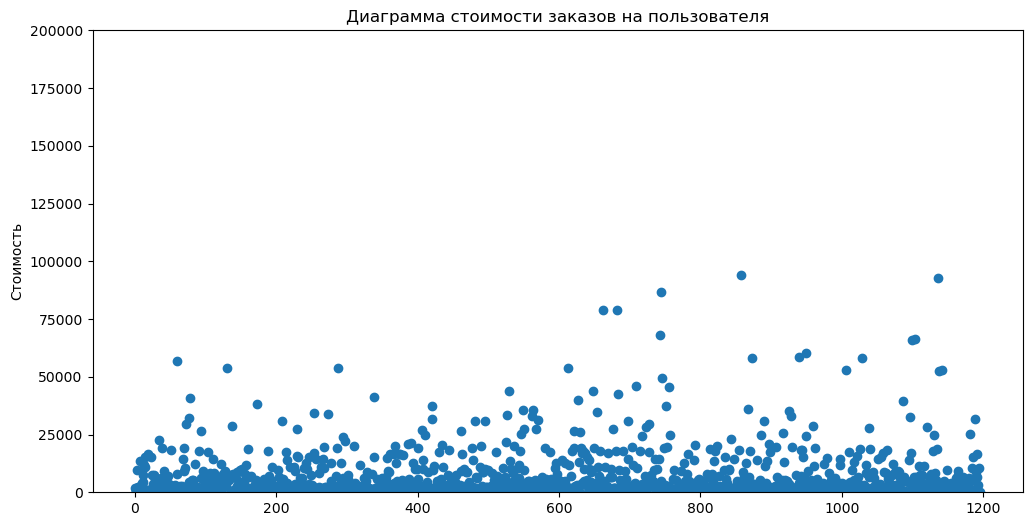

In [22]:
#аналогичная диаграмма в более точном масштабе
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 200000)
plt.title('Диаграмма стоимости заказов на пользователя')
plt.ylabel('Стоимость');

Большая часть пользователей делают заказы на сумму до 25000 р.
Но также видны выборсы намного больших заказов и 1 четко выделяющий заказ на 1,2 млн р. 
Он конечно же будет сильно искажать общую картину и такие выбросы надо обязательно исключать из анализа.

Кстати, есть продположение, что именно такой заказ и был сделан в районе 18 числа, поскольку именно в этот период был очень резкий скачок по выручке и другим показателям.

Чтобы узнать точные цифры границы стоимостей заказов посчитаем перцентили на 95 и 99%.

### Перцентили стоимости заказов

In [23]:
#посчитаем 95 и 99 перцентили стоимости заказов на одного пользователя
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Итак, мы видим, что менее 5% пользователей совершают покупки на сумму более 28000 р. \
И менее 1% посетителей - на сумму более 58000 р.\
Можно взять усредненные цифры и в качестве аномальных значений (выбросов) считать стоимости заказов более 40000 р.

### Стат значимость различий в среднем кол-ве заказов на посетителя, сырые данные

Итак, для начала мы не будем удалять аномально большие значения и посчитаем стат значимость различий 
в среднем количестве заказов на посетителя по всем данных, без удаления.

Сформулируем гипотезы. \
<b>H0 (нулевая):</b> Различий в среднем количестве заказов на посетителя между группами нет. \
<b>H1 (альтернативная):</b> Различия в среднем кол-ве заказов на посетителя между группами есть.

Для исследования будем использовать непараметрический метод - критерий Манна-Уитни.
Этот метод хороши применим для наших данных поскольку в них присутствуют выбросы, которые могут исказить результаты. А также поскольку для непараметр. метода не требуется преположения нормальности распределния.

In [24]:
#Создадим переменные для пользователей, которые заказывали хотя бы 1 раз, и укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [25]:
#создадим переменные и подготовим данные к проверке критерием Манна-Уитни ( если заказа не было, то отобразится 0)
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visA\
                    - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visB \
                    - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

#применим критерий Манна-Уитни и выведем на экран p_value, округленное до 3 знаков после запятой
print('Значение p_value',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост группы В', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Значение p_value 0.017
Относительный прирост группы В 0.138


Итак, стат значимость меньше 0,05, значит нулевую гипотезу отвергаем. \
Соответственно, различия в среднем количестве заказов на посетителя между группами есть.

Относительный прирост среднего числа заказов на посетителя группы В положительный и равен 13%. \
Это означает, что в группе В на 13% большее кол-во заказов на посетителя, относительно группы А. 

### Стат значимость различий в среднем чеке заказа, «сырые» данные

Посчитаем аналогично стат значимость, но по различию среднего чека между группами А и В по сырым данным.

Сформулируем гипотезы: \
H0 (нулевая): Различий в среднем чеке заказа между группами нет. \
H1 (альтернативная): Различия в среднем чеке заказа между группами есть.

In [26]:
#примерним критерий Манна-Уитни в разрезе данных о выручке с заказов
print('Значение p_value', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост группы В', '{0:.3f}'.format(orders[orders['group']=='B']\
                       ['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Значение p_value 0.729
Относительный прирост группы В 0.259


p_value имеет очень большой показатель, 72%! Однозначно не можем отвергнуть нулевую гипотезу, \
т.е. с большой вероятностью различий в среднем чеке между группами нет. Вероятность составляет 72%.

Относит прирост среднего чека группы В относит А составляет 25%. Т.е. чек увеличился на 25% относит группы А.

 ### Стат значимость различий в среднем количестве заказов на посетителя по «очищенным» данным

По сырым данным все характеристики посчитали и результаты поразительно хорошие, группа В идет с большим отрывом от гр А. \
Но все ли будет так хорошо , если очистим данные от аномалий.

Этим сейчас и займемся.

Примем за аномальных пользователей тех, кто делает больше 3 заказов и у кого выручка с заказа более 40000. \
Подсчет этих показателей мы произвели с разделе перцентилей.

In [27]:
#сделаем срез пользователей, кто делает > 3 заказов ( это относится к 2% пользователей)
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 98)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 98)]['userId'],
    ],
    axis=0,
)

#сделаем срез пользователей, у кого выручка заказа > чем у 2% пользователей
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 98)]['transactionId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

#посчитаем количесво аномальных пользователей
print(abnormalUsers.shape[0]) 

858     192721366
18      199603092
23      237748145
1099    316924019
1029    469609643
dtype: int64
33


Итак, имеем 33 аномальных пользователя.

Наша задача посчитать стат значимости среднего кол-ва заказов на посетителя и среднего чека, но уже по очищенным данным. \
И на основе этого сформулировать вывод.

In [28]:
#определим относительную долю анломальных пользователей ко всем уникальным пользователям теста
abnormal_share = abnormalUsers.count() / pd.Series(orders['visitorId'].unique()).count()
print('Относит количество аномальных пользователей', "{0:.2%}".format(abnormal_share))

Относит количество аномальных пользователей 3.20%


33 пользователя и 3,2% потерь не так много. Так что скорее всего, убрав эти выбросы, общая картина станет еще ближе к реальности.

In [29]:
#отфильтруем данные
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visA - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visB - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [30]:
# применим статистический критерий Манна-Уитни к полученным выборкам
print('Значение p_value', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост группы В', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


Значение p_value 0.016
Относительный прирост группы В 0.147


Результаты практически не изменились. 
P_value также ниже 0.05, а относит прирост положит и составляет 14% вместо 13%.

### Стат значимость различий в среднем чеке по «очищенным» данным

In [31]:
#аналогично применим критерий Манна-Уитни к среднему чеку заказа между группами
print('Значение p_value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный прирост группы В',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


Значение p_value 0.899
Относительный прирост группы В 0.238


Картина приниципиально не изменилась, правда p_value стал еще больше и составляет целых 90%. \
Нулевую гипотезу не отвергаем однозначно, потому что с вероятностью 90% различий в среднем чеке нет.

Относит прирост группы В - в плюс и почти 24%.

### Вывод

Итак, мы построили графики кумулятивной выручки по группам А и В, по среднему чеку и количеству заказов на посетителя в разных интерпретациях. 
Также посчитали точно перцентили, которые показывают какую долю пользователей считать аномальной и отфильтровать ее. 
И в конце посчитали стат значимость различий между группами по среднему чеку и количеству заказов на посетителя.

Что мы имеем:\
    - по сырым и очищенным данным нет различий между группами в среднем количестве заказов на посетителя.\
    - есть различия между группами в среднем чеке с высокой долей вероятности и по сырым и по очищенным данным.\
    - график относительного различия для среднего чека показывает, что результаты группы В лучше, чем А практически на протяжении всего теста.\
    - график относительного изменения кумулятивного среднего кол-ва заказов говорит также о положит результатах группы В по сравнению с А.
    
На основе полученных результатов можно сказать, что тест точно удался, показатели группы В почти всегда выше нежели у гр А. И по окончании теста группа В лидирует. 
По среднему количеству заказов на посетителя различий нет, различия связаны с увеличением среднего чека по заказу. В связи с этим кумулятивная выручка выросла и результат группы В лучше чем у группы А.

На данном этапе считаю тест успешно завершенным, тест длился месяц и за это время мы успели собрать достаточное количество данных.